In [ ]:
import nltk
import os,sys
from io import open
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from itertools import chain
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

!pip install sklearn-crfsuite
import sklearn_crfsuite 
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



     |████████████████████████████████| 747kB 6.0MB/s 
--2020-10-03 22:51:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-03 22:51:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-03 22:51:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822

In [ ]:
import nltk
import os,sys
from io import open
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from itertools import chain
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
train = open("train.txt", "r")
test = open("test.txt", "r")
train_lines = train.readlines()
test_lines = test.readlines()

train_sentences  = [ [] for _ in range(8936) ]
train_chunks = [ [] for _ in range(8936) ]
j = 0
for line in train_lines:
  if line == '\n':
    j = j+1
  else:
    train_sentences[j].append((line.split()[0], line.split()[1], line.split()[2].split('-')[0]))
    train_chunks[j].append(line.split()[2].split('-')[0])

test_sentences  = [ [] for _ in range(2012) ]
test_chunks = [ [] for _ in range(2012) ]
j = 0
for line in test_lines:
  if line == '\n':
    j = j+1
  else:
    test_sentences[j].append((line.split()[0], line.split()[1], line.split()[2].split('-')[0]))
    test_chunks[j].append(line.split()[2].split('-')[0])

stemmer = SnowballStemmer("english")

In [ ]:
def get_features(word):
    word = word.lower()
    try:
         vector = embeddings_index[word]
    except:
        # if the word is not in vocabulary,
        # returns zeros array
        vector=np.zeros(300,)

    return vector  

def word2features(sent, i):
    word = sent[i][0]
    wordembdding = get_features(word)
    postag = sent[i][1]
    stem_word = stemmer.stem(word)
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word_suffix[-3:]': word[-3:],
        'word_suffix[-2:]': word[-2:],
        'word_suffix[-1:]': word[-1:],
        'word_prefix[-3:]': word[:3],
        'word_prefix[-2:]': word[:2],
        'word_prefix[-1:]': word[:1],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        #'postag': postag,
        'stem': stem_word
    }
    for iv,value in enumerate(wordembdding):
        features['v{}'.format(iv)] = value
    if i > 0:
        previous_word = sent[i-1][0]
        previous_word_postag = sent[i-1][1]
        previous_word_chunk = sent[i-1][2]
        previous_wordembedding = get_features(previous_word)
        features.update({
            '-1:word.lower()': previous_word.lower(),
            '-1:word.istitle()': previous_word.istitle(),
            '-1:word.isupper()': previous_word.isupper(),
            '-1:word.isdigit()': previous_word.isdigit(),
            #'-1:postag': previous_word_postag,
            '-1:chunk': previous_word_chunk,
        })
        for iv,value in enumerate(previous_wordembedding):
          features['-1:v{}'.format(iv)] = value
        
        if i > 1:
          pre_pre_word = sent[i-2][0]
          pre_pre_word_postag = sent[i-2][1]
          pre_pre_word_chunk = sent[i-2][2]
          pre_pre_wordembedding = get_features(pre_pre_word)
          features.update({
            '-2:word.lower()': pre_pre_word.lower(),
            '-2:word.istitle()': pre_pre_word.istitle(),
            '-2:word.isupper()': pre_pre_word.isupper(),
            '-2:word.isdigit()': pre_pre_word.isdigit(),
            #'-2:postag': pre_pre_word_postag,
            '-2:chunk': pre_pre_word_chunk,
          })
          for iv,value in enumerate(pre_pre_wordembedding):
            features['-2:v{}'.format(iv)] = value

        else:
          features['second_word'] = True

        
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        next_word = sent[i+1][0]
        next_word_postag = sent[i+1][1]
        next_wordembedding = get_features(next_word)
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
            '+1:word.isdigit()': next_word.isdigit(),
            #'+1:postag': next_word_postag,
        })
        for iv,value in enumerate(next_wordembedding):
          features['+1:v{}'.format(iv)] = value
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for label in sent]



In [ ]:
X_train = [sent2features(s) for s in train_sentences]
y_train = [sent2labels(s) for s in train_chunks]

X_test = [sent2features(s) for s in test_sentences]
y_test = [sent2labels(s) for s in test_chunks]

In [ ]:
!pip install sklearn-crfsuite
import sklearn_crfsuite 
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm = 'l2sgd',
    c2 = 1,
    max_iterations = 1000,
    all_possible_transitions = True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='l2sgd', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=None, c2=1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=1000,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B', 'I']

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.9468818196865595

In [ ]:
metrics.flat_precision_score(y_test, y_pred,average='weighted', labels=labels )

0.9472851223942946

In [ ]:
metrics.flat_recall_score(y_test, y_pred,average='weighted', labels=labels )

0.9634924873170376

In [ ]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           B      0.966     0.939     0.952     23852
           I      0.922     0.958     0.940     17345

   micro avg      0.947     0.947     0.947     41197
   macro avg      0.944     0.948     0.946     41197
weighted avg      0.947     0.947     0.947     41197



In [ ]:
import pandas as pd
chunk_list = ['B','I','O']
conf_mat_df = pd.DataFrame(columns=chunk_list, index=chunk_list)
conf_mat_df = conf_mat_df.fillna(0)

for sen_num in range(len(test_chunks)):
  for i,chunk in enumerate(test_chunks[sen_num]):
    conf_mat_df[chunk][y_pred[sen_num][i]] +=1

In [ ]:
conf_mat_df

,B,I,O
B,22397,698,97
I,1394,16616,13
O,61,31,6070


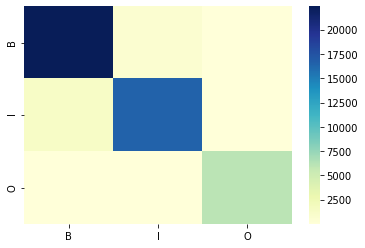

In [ ]:
import seaborn as sns

sns.heatmap(conf_mat_df, cmap="YlGnBu")